<br>
<br>

# Sentiment Classification
***Reynaldo Vazquez***  
***April, 2018***

**[GitHub Pages](https://reyvaz.github.io/Sentiment-Analysis-Mobile/)**

## Sentiment Classification on Mobile Phone User Reviews

Different specifications of Multinomial Naïve-Bayes, Logistic-Regression, and Support Vector Machine, with varying features complexities were tested in order to classify user reviews as positive or negative. This notebook reports on the best performing model tested, which is a Logistic Regression on words, bigrams, and trigrams. The model achieves 99% precision and recall, 98% accuracy, and 97% ROC AUC. 

The dataset used contains over 400,000 reviews of mobile phones sold on Amazon extracted by [PromptCloud](https://www.promptcloud.com/). It was downloaded from [Kaggle](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones) on November 16, 2017. From this dataset, only the columns `Rating` and `Review` were used. 

The dataset does not contain actual positive or negative labels, sentiments were implied from ratings left by the reviewing customers. The original ratings consist of a scale from 1 to 5, with 5 as the most favorable rating. Ratings of 4 and 5 were assumed to be positive, 1 and 2 negative, and 3 neutral. Reviews deemed neutral were discarded. With this scheme, ~3/4 of the reviews in the original dataset were labeled as positive and ~1/4 as negative. 

- `sentiment_utils.py` can be found [here](link)
- `cm_heat_plots.py` can be found [here](link)


<img src="media/mobile_phone.png" style="width:200px;padding:30px" align="left">

#### Model Performance Metrics
```
Model: Logistic Regression 
Train Accuracy = 1.00
Test Accuracy  = 0.98
Recall  = 0.99
Precision  = 0.99
ROC AUC  = 0.97
```

### Packages

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from cm_heat_plots import *
from my_nlp_paths import *
from sentiment_utils import *
import time
np.random.seed(1)
%matplotlib inline

### Data Processing

In [2]:
df = pd.read_csv(reviews_data_path, usecols = [3, 4])
df.columns = df.columns.str.lower()
print('Imported data shape: ', df.shape)
print('Column names:', list(df.columns))
print('Original rating levels:', sorted(df['rating'].unique()))

Imported data shape:  (413840, 2)
Column names: ['rating', 'reviews']
Original rating levels: [1, 2, 3, 4, 5]


In [3]:
nans = df.isnull().any(axis = 1)
print(nans.sum(), 'rows contain NaN')
df.dropna(inplace=True)
print('Shape after dropping NaNs:', list(df.shape))

62 rows contain NaN
Shape after dropping NaNs: [413778, 2]


In [4]:
print('Total neutral raitings:', sum(df['rating'] == 3))
df = df[df['rating'] != 3]
print('Shape after elimintating neutral ratings:', list(df.shape))

Total neutral raitings: 31763
Shape after elimintating neutral ratings: [382015, 2]


In [5]:
df = df.assign(positive = np.where(df['rating'] > 3, 1, 0))
print('Fraction of positive ratings:', df['positive'].mean())

Fraction of positive ratings: 0.7459235893878513


In [6]:
classes_dict = {0:'Negative', 1:'Positive'}
classes = list(classes_dict.values())
print("Created classes:\n" + str(classes))

Created classes:
['Negative', 'Positive']


In [7]:
review_lengths = [len(x.split()) for x in df["reviews"]]
max_len =  np.max(review_lengths)
mean_len = np.mean(review_lengths)
median_len = np.median(review_lengths)
print("max review length (word count):", max_len)
print("average review length:", mean_len)
print("median review length:", median_len)

max review length (word count): 5313
average review length: 39.20512807088727
median review length: 17.0


#### Split dataset for training and testing

In [8]:
Y = df['positive']
X = df['reviews']

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('Fraction of positive reviews in training dataset:', Y_train.mean())

X_train shape: (286511,)
Y_train shape: (286511,)
Fraction of positive reviews in training dataset: 0.7463587785460244


### Training and reporting function
Trains and returns the trained specified model. Prints model performance metrics.

In [10]:
def run_model(X_train, Y_train, X_test, Y_test, model):
    """
    Trains the specified model, calculates predictions, and returns and prints the
    classification report and performance metrics.
    """
    print("Model:", str(model).split("(")[0], "\n")
    start_time = time.time()
    trained_model = model.fit(X_train, Y_train)
    elapsed_time = time.time() - start_time
    predicted_Y_test = trained_model.predict(X_test)
    predicted_Y_train = trained_model.predict(X_train)
    train_acc = accuracy_score(Y_train, predicted_Y_train)
    test_acc = accuracy_score(Y_test, predicted_Y_test)
    auc  = roc_auc_score(Y_test, predicted_Y_test)
    prec = precision_score(Y_test, predicted_Y_test)
    rec  = recall_score(Y_test, predicted_Y_test)
    print("Train Accuracy =", str(format(train_acc, '.2f')))
    print("Test Accuracy  =", str(format(test_acc, '.2f')))
    print("Recall  =", str(format(rec, '.2f')))
    print("Precision  =", str(format(prec, '.2f')))
    print("ROC AUC  =", str(format(auc, '.2f')))
    print("Training time:", int(elapsed_time), "seconds")
    return trained_model

### Feature specification:  words, bigrams, and trigrams with document frequency > 1
Ignoring terms that have a document frequency strictly lower than 2

In [11]:
vect = CountVectorizer(min_df=2, ngram_range=(1,3)).fit(X_train)
X_train_vect = vect.transform(X_train)
X_test_vect  = vect.transform(X_test)

### Logistic Regression Model

In [12]:
lr = LogisticRegression(C = 10)
lr_trained = run_model(X_train_vect, Y_train, X_test_vect, Y_test, lr)

Model: LogisticRegression 

Train Accuracy = 1.00
Test Accuracy  = 0.98
Recall  = 0.99
Precision  = 0.99
ROC AUC  = 0.97
Training time: 241 seconds


### Influential Features

In [13]:
coefficients = lr_trained.coef_[0]
features = influential_features(coefficients, vect, num_features = 12)

In [14]:
print("Influential positive features (coefficients):\n")
print(features[0], "\n")
print("Influential negative features (coefficients):\n")
print(features[1])

Influential positive features (coefficients):

excelent       5.837680
not bad        5.353443
excellent      4.939210
perfect        4.794807
excelente      4.673470
no problems    4.134251
awesome        3.991098
amazing        3.843660
great          3.780663
exelente       3.726202
no issues      3.649203
no problem     3.398192
dtype: float64 

Influential negative features (coefficients):

no good     -5.347942
junk        -4.799142
not good    -4.274680
worst       -4.196605
horrible    -4.153863
terrible    -3.990539
poor        -3.692953
garbage     -3.658424
nope        -3.562117
sucks       -3.538783
awful       -3.420538
defective   -3.360209
dtype: float64


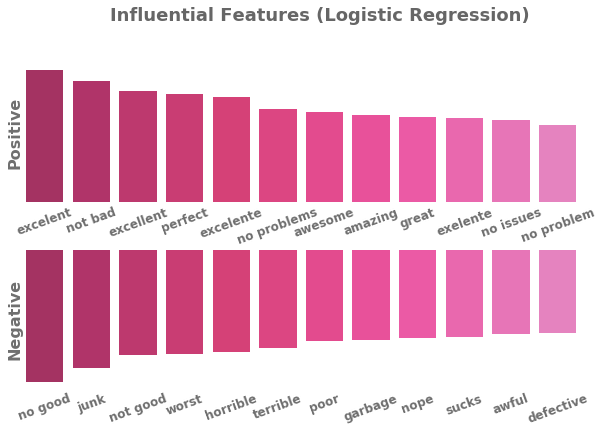

In [15]:
plot_features(features, "Logistic Regression", classes = classes, label_rotation = 20, save_fig = False)

### Prediction time and confusion matrix

In [16]:
lr_predictions = predict_and_time(lr_trained, X_test_vect)

Time to calculate 95504 predictions with LogisticRegression model: 0.1197 seconds


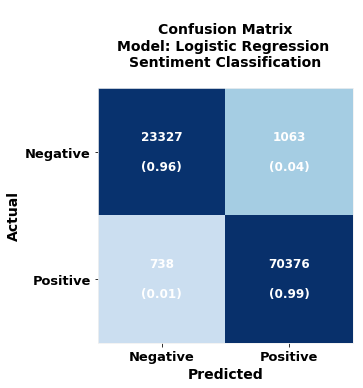

In [17]:
cm_lr = confusion_matrix(Y_test, lr_predictions)
heated_confusion_matrix(cm = cm_lr, labels = classes, cmap = plt.cm.Blues, 
                        contrast = 3, model_name = "Logistic Regression \nSentiment Classification", 
                        p_size = 5.5, save_fig = False)